In [1]:
import os
import s3prl.hub as hub
import torch
import soundfile as sf
import librosa
import pickle

import torchaudio
from torchaudio.models.rnnt import _Predictor
import torchaudio.transforms as transforms
from torchaudio.functional import resample
import torch.nn.functional as F
import time
from sklearn.cluster import KMeans
import IPython.display as display
import numpy as np

from soft_vc_wavlm.acoustic_model.acoustic_model import AcousticModel
from importlib import reload
import soft_vc_wavlm.acoustic_model.acoustic_model
reload(soft_vc_wavlm.acoustic_model.acoustic_model)
import matplotlib.pylab as plt
import faiss
%matplotlib inline

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream
/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LogMelSpectrogram(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.melspctrogram = transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            win_length=1024,
            hop_length=160,
            center=False,
            power=1.0,
            norm="slaney",
            onesided=True,
            n_mels=128,
            mel_scale="slaney",
        )

    def forward(self, wav):
        padding = (1024 - 160) // 2
        wav = F.pad(wav, (padding, padding), "reflect")
        mel = self.melspctrogram(wav)
        logmel = torch.log(torch.clamp(mel, min=1e-5))
        return logmel

In [3]:
device = "cuda:2"

In [56]:
model_name = "wavlm_large"
wavlm_model = getattr(hub, model_name)()

device = "cuda:2"
wavlm_model = wavlm_model.to(device)

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [57]:
#wav, sr = torchaudio.load("audios/wav/mngu0_s1_1263.wav")
#wav_t = torch.from_numpy(wav).float().unsqueeze(0).to(device)
wav = wav.to(device)
print(len(wav[0]))

154481


In [58]:
with torch.no_grad():
    states = wavlm_model(wav)["hidden_states"]

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [59]:
# Take 10th layer of WavLM
feature = states[9].squeeze(0)

In [60]:
#feature = feature.long().to(device)
print(feature.shape)

torch.Size([482, 1024])


In [61]:
#kmeans = KMeans(n_clusters=100).fit(feature.cpu().numpy())
kmeans = pickle.load(open("soft_vc_wavlm/acoustic_model/kmeans_ckpt/kmeans_100_trained.pkl", "rb"))

In [62]:
feature_kmeans = torch.tensor(kmeans.predict(feature.cpu().numpy())).to(device)
length = 2 * feature_kmeans.shape[0]

In [63]:
melspectrogram = LogMelSpectrogram()
wav, sr = torchaudio.load("../LJSpeech-1.1/wavs/LJ001-0001.wav")
#wav, sr = torchaudio.load("audios/wav/mngu0_s1_0001.wav")
wav = resample(wav, sr, 16000)
mel = melspectrogram(wav.unsqueeze(0)).squeeze(0).transpose(2, 1).to(device)[:, :length, :]

#mel = F.pad(mel, (0, 0, 1, 0))

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [64]:
print(mel.shape)
print(feature_kmeans.unsqueeze(0).shape)

torch.Size([1, 964, 128])
torch.Size([1, 482])


time for half the audio -> WavLM: 2.53 sec (100 iterations)

time for half the audio -> WavLM: 26.13 sec (1000 iterations)

time for full audio -> WavLM: 2.84 sec (100 iterations)

time for full audio -> WavLM: 31.42 sec (1000 iterations)

In [51]:
feature_kmeans = np.load("../LJSpeech-1.1/wavlm_clustered/LJ001-0001.npy")
#feature_kmeans = np.load("audios/wavlm_clustered/mngu0_s1_0001.npy")
print(feature_kmeans.shape)
feature_kmeans = torch.tensor(feature_kmeans).to(device)

(665,)


In [46]:
max(feature_kmeans)

tensor(99, device='cuda:2', dtype=torch.int32)

In [47]:
wavlm_acoustic = AcousticModel(discrete=True).to(device)

In [48]:
wavlm_acoustic(feature_kmeans.long().unsqueeze(0), mel).shape

torch.Size([1, 360, 128])

In [35]:
state_dict = torch.load("soft_vc_wavlm/acoustic_model/ckpts/model-best.pt")["acoustic-model"]
changed_state_dict = {}
for key in state_dict.keys():
    changed_state_dict[key[7:]] = state_dict[key]
trained_acoustic = AcousticModel(discrete=True).to(device)
trained_acoustic.load_state_dict(changed_state_dict)

<All keys matched successfully>

In [37]:
pred_mels = trained_acoustic(feature_kmeans.unsqueeze(0), mel).squeeze(0)
pred_mels = pred_mels.cpu().detach().numpy()

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1330 but got size 965 for tensor number 1 in the list.

In [50]:
mel_np = mel.squeeze(0).cpu().detach().numpy()

In [51]:
pred_mels.shape

(212, 128)

[Text(0.5, 1.0, 'Ground Truth Mel Spectrogram')]

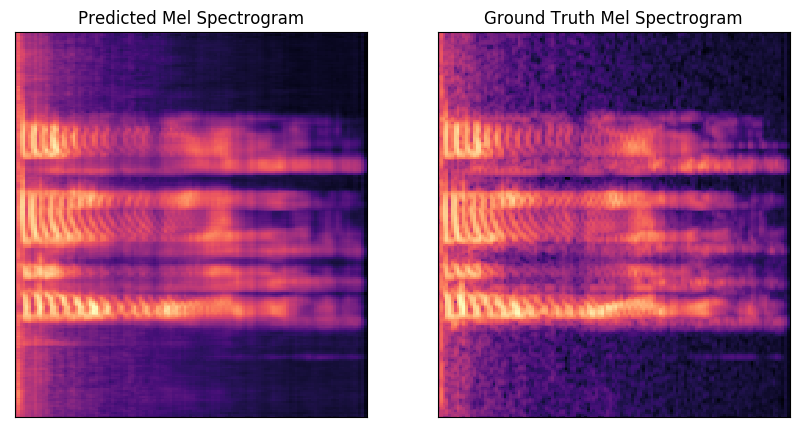

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
librosa.display.specshow(pred_mels, ax=ax[0])
ax[0].set(title="Predicted Mel Spectrogram")

librosa.display.specshow(mel_np, ax=ax[1])
ax[1].set(title="Ground Truth Mel Spectrogram")

In [29]:
hifigan = torch.hub.load("bshall/hifigan:main", "hifigan_hubert_discrete", trust_repo=True).to(device)

Using cache found in /home/prabhune/.cache/torch/hub/bshall_hifigan_main
/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [53]:
print(pred_mels)
with torch.inference_mode():
    target = hifigan(torch.tensor(pred_mels.transpose()).to(device))

[[ -4.330773   -4.275097   -4.5952673 ...  -8.810197   -9.615801
  -10.389139 ]
 [ -4.2769866  -3.9405236  -4.5469613 ...  -8.90839    -9.6014385
  -10.332056 ]
 [ -4.1833     -3.630101   -4.3367934 ...  -9.076842   -9.748647
  -10.453773 ]
 ...
 [ -4.271722   -3.6647131  -4.8267884 ...  -9.315921   -9.878646
  -10.591741 ]
 [ -4.078005   -3.4436955  -4.5028853 ...  -9.277683   -9.696539
  -10.387129 ]
 [ -4.1130342  -3.5083418  -4.605821  ...  -9.247222   -9.70831
  -10.351102 ]]


In [54]:
display.Audio(target.squeeze().cpu(), rate=16000)

In [33]:
torchaudio.save("soft_vc_wavlm/vocoder/pretrain_examples/mngu0_s1_1263.wav",
                target.cpu(),
                sample_rate=sr)

In [8]:
ncentroids = 100
niter = 20
verbose = True
d = 1024
#kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose, gpu=1)
#kmeans.train(feature.cpu().numpy())

In [9]:
print(feature.shape)

NameError: name 'feature' is not defined

In [73]:
D, I = kmeans.assign(feature.cpu().numpy())

In [70]:
D.shape

(149,)

In [10]:
checkpoint_path = os.path.join("soft_vc_wavlm/acoustic_model/kmeans_ckpt/", f"kmeans_LJ_100_faiss.npy")
#with open(checkpoint_path, "rb") as f:
    #kmeans = pickle.load(f)
centroids = np.load(checkpoint_path)
kmeans = faiss.Kmeans(d, ncentroids, niter=0, verbose=verbose, gpu=True)

In [15]:
feature = np.load("../LJSpeech-1.1/wavlm_raw/LJ001-0001.npy")
print(feature.shape)

(665, 1024)


In [16]:
kmeans.train(feature)
kmeans.centroids = centroids

WARNING clustering 665 points to 100 centroids: please provide at least 3900 training points


Clustering 665 points in 1024D to 100 clusters, redo 1 times, 0 iterations
  Preprocessing in 0.00 s



In [23]:
_, feature_kmeans_load = kmeans.assign(feature)

In [24]:
feature_kmeans_load.shape

(665,)

In [26]:
max(feature_kmeans_load)

99